In [209]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

data_dir = "AudioWAV/"
emotion_map = {
    "ANG": "Anger",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

file_paths = []
labels = []

for fname in os.listdir(data_dir):
    if fname.endswith(".wav"):
        parts = fname.split("_")
        emotion_code = parts[2]
        if emotion_code in emotion_map:
            file_paths.append(os.path.join(data_dir, fname))
            labels.append(emotion_map[emotion_code])

In [210]:
import librosa

def extract_mel_spectrogram(file_path, n_mels=256, max_len=256):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel_spec)

    # Pad or truncate to fixed length
    if log_mel.shape[1] < max_len:
        pad_width = max_len - log_mel.shape[1]
        log_mel = np.pad(log_mel, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        log_mel = log_mel[:, :max_len]

    return log_mel

In [211]:
X = []
for path in file_paths:
    spec = extract_mel_spectrogram(path)
    X.append(spec)

X = np.array(X)
X = X[..., np.newaxis]  # (samples, 128, 128, 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Normalize
X = X / np.max(X)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [226]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

model.save("cnn_emotion_model.h5")



/Users/shrek/Desktop/courses/semester 8/nlp/NLP-CS4420/project/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 81s 476ms/step - accuracy: 0.3150 - loss: 1.6733 - val_accuracy: 0.4440 - val_loss: 1.3821
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 84s 498ms/step - accuracy: 0.4408 - loss: 1.3826 - val_accuracy: 0.4567 - val_loss: 1.3479
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 93s 551ms/step - accuracy: 0.4885 - loss: 1.3034 - val_accuracy: 0.4903 - val_loss: 1.3166
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 592ms/step - accuracy: 0.5202 - loss: 1.2209 - val_accuracy: 0.5097 - val_loss: 1.2733
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 99s 589ms/step - accuracy: 0.5749 - loss: 1.1106 - val_accuracy: 0.5396 - val_loss: 1.1934
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 104s 619ms/step - accuracy: 0.6219 - loss: 0.9884 - val_accuracy: 0.5425 - val_loss: 1.1993
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 100s 593ms/step - accuracy: 0.6529 - loss: 0.9083 - val_accuracy: 0.5485 - val_loss: 1.2250
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 100s 596ms/step - accuracy: 0.7047 - loss

In [227]:
from tensorflow.keras.models import load_model
# Load model and label encoder
model = load_model("cnn_emotion_model.h5")
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

def predict_emotion_from_audio(audio_path):
    # Load audio
    y, sr = librosa.load(audio_path, sr=22050)
    
    # Extract Mel spectrogram with 256 Mel bands
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Resize time dimension to 256
    if mel_db.shape[1] < 256:
        pad_width = 256 - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :256]

    # Reshape for CNN input
    mel_db = mel_db.reshape(1, 256, 256, 1)
    mel_db = mel_db / np.max(mel_db)

    # Predict
    prediction = model.predict(mel_db)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]


In [228]:

# Example usage
print(predict_emotion_from_audio("AudioWAV/1083_IOM_FEA_XX.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Anger


/var/folders/5v/19pdwzv572b5vtt6l96sc4t40000gn/T/ipykernel_91190/2509112444.py:24: RuntimeWarning: divide by zero encountered in divide
  mel_db = mel_db / np.max(mel_db)
/var/folders/5v/19pdwzv572b5vtt6l96sc4t40000gn/T/ipykernel_91190/2509112444.py:24: RuntimeWarning: invalid value encountered in divide
  mel_db = mel_db / np.max(mel_db)


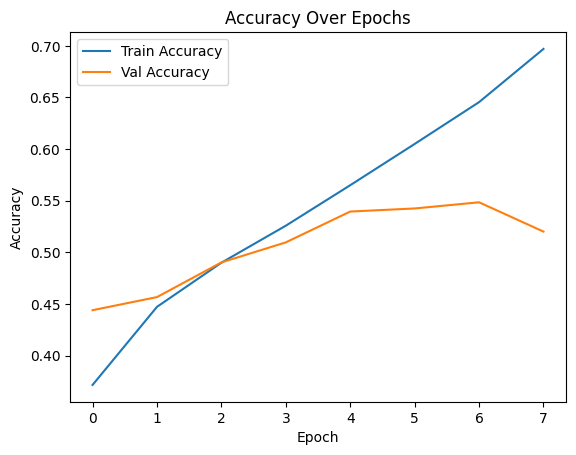

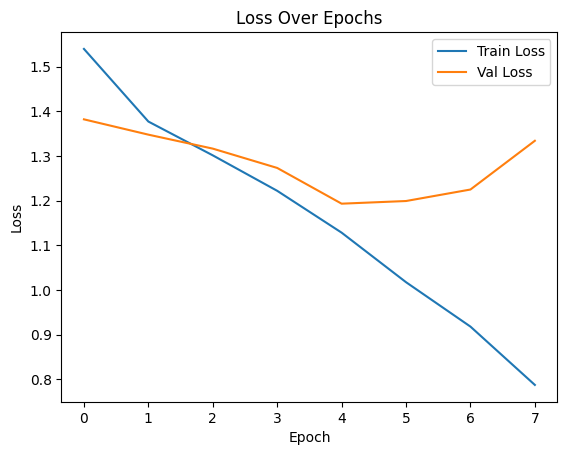

In [229]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [230]:
from collections import Counter
print(Counter(labels))

Counter({'Anger': 1271, 'Disgust': 1271, 'Sad': 1271, 'Fear': 1271, 'Happy': 1271, 'Neutral': 1087})
